In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/Bacteria_Dataset

!wget --no-check-certificate --content-disposition \
"https://zenodo.org/record/10526360/files/DeepDataSet.zip?download=1" \
-O /content/drive/MyDrive/Bacteria_Dataset/DeepDataSet.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2025-10-11 08:00:39--  https://zenodo.org/record/10526360/files/DeepDataSet.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/10526360/files/DeepDataSet.zip [following]
--2025-10-11 08:00:40--  https://zenodo.org/records/10526360/files/DeepDataSet.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1879959651 (1.8G) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Bacteria_Dataset/DeepDataSet.zip’

/content/drive/MyDr 100%[===================>]   1.75G  2.51MB/s    in 9m 59s  

2025-10-11 08:10:39 (2.99 MB/s) - ‘/content/drive/MyDrive/Bacteria_Dataset/DeepDataSet.zip’ saved [1879959651/1879

In [ ]:
!rm -rf "/content/drive/MyDrive/GRAM_BACTERIA/DeepData"


In [ ]:
!mkdir -p "/content/drive/MyDrive/GRAM_BACTERIA"
!unzip -q "/content/drive/MyDrive/GRAM_BACTERIA/DeepDataSet.zip" -d "/content/drive/MyDrive/GRAM_BACTERIA"


In [ ]:
!pip -q install ultralytics==8.3.18
import os, glob, json, shutil
base = "/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet"
print("Base exists?", os.path.exists(base))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 26.1 MB/s eta 0:00:00
Base exists? True


In [ ]:
import os, itertools

for sub in ["images","labels","txt"]:
    p = os.path.join(base, sub)
    print(sub, "->", "OK" if os.path.exists(p) else "MISSING")
    if os.path.exists(p):
        # show a few files
        files = list(itertools.islice((f for f in glob.iglob(p+'/**/*', recursive=True)), 5))
        print("  sample:", files)


images -> OK
  sample: ['/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/images/000001_2_3.jpg', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/images/000002_2_6.jpg', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/images/000003_0_5.jpg', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/images/000003_1_4.jpg', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/images/000003_2_4.jpg']
labels -> OK
  sample: ['/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000001_2_3.txt', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000002_2_6.txt', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000003_0_5.txt', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000003_1_4.txt', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000003_2_4.txt']
txt -> OK
  sample: ['/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/txt/test.txt', '/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/txt/train.txt', 

In [ ]:
import os, random, shutil, glob
from pathlib import Path

img_root = os.path.join(base, "images")
lab_root = os.path.join(base, "labels")

# Detect if already split
already_split = all(os.path.isdir(os.path.join(img_root, d)) for d in ["train","val"]) and \
                all(os.path.isdir(os.path.join(lab_root, d)) for d in ["train","val"])

print("Already split?", already_split)

if not already_split:
    # create split dirs
    for d in ["train","val","test"]:
        os.makedirs(os.path.join(img_root, d), exist_ok=True)
        os.makedirs(os.path.join(lab_root, d), exist_ok=True)

    # gather flat images and labels
    imgs = sorted([p for p in glob.glob(os.path.join(img_root, "**","*.jpg"), recursive=True)] +
                  [p for p in glob.glob(os.path.join(img_root, "**","*.png"), recursive=True)] +
                  [p for p in glob.glob(os.path.join(img_root, "**","*.jpeg"), recursive=True)])
    # try to exclude already-in-train/val/test if they existed
    imgs = [p for p in imgs if "/train/" not in p and "/val/" not in p and "/test/" not in p]

    # pair with labels by name
    pairs = []
    for ip in imgs:
        lp = os.path.join(lab_root, os.path.splitext(os.path.basename(ip))[0] + ".txt")
        if not os.path.exists(lp):
            # also check nested labels if any
            candidates = glob.glob(os.path.join(lab_root, "**", os.path.basename(lp)), recursive=True)
            if candidates:
                lp = candidates[0]
        if os.path.exists(lp):
            pairs.append((ip, lp))

    print(f"Found {len(pairs)} image/label pairs.")
    random.seed(42)
    random.shuffle(pairs)
    n = len(pairs)
    n_train = int(0.8*n)
    n_val   = int(0.1*n)
    n_test  = n - n_train - n_val
    splits = {"train": pairs[:n_train], "val": pairs[n_train:n_train+n_val], "test": pairs[n_train+n_val:]}

    # move (copy to be safe; change to shutil.move if you want)
    def cp(src, dst_dir):
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy2(src, os.path.join(dst_dir, os.path.basename(src)))

    for split, items in splits.items():
        for ip, lp in items:
            cp(ip, os.path.join(img_root, split))
            cp(lp, os.path.join(lab_root, split))

    print({k: len(v) for k,v in splits.items()})
else:
    print("Using existing train/val/test splits.")


Already split? False
Found 6005 image/label pairs.
{'train': 4804, 'val': 600, 'test': 601}


In [ ]:
import os
import glob

base_path = "/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet"

# Paths
images_path = os.path.join(base_path, "images")
labels_path = os.path.join(base_path, "labels")

# Allowed folders
allowed = ["train", "val", "test"]

# Delete extra images
extra_images = [f for f in glob.glob(os.path.join(images_path, "*")) if os.path.isfile(f)]
for f in extra_images:
    print("Deleting extra image:", f)
    os.remove(f)

# Delete extra labels
extra_labels = [f for f in glob.glob(os.path.join(labels_path, "*")) if os.path.isfile(f)]
for f in extra_labels:
    print("Deleting extra label file:", f)
    os.remove(f)

print("✅ Cleanup complete! Only train/val/test remain.")


Streaming output truncated to the last 5000 lines.
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000143_3_7.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000143_3_8.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000143_4_2.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000144_0_0.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000144_0_5.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000144_0_6.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000144_1_2.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000144_1_3.txt
Deleting extra label file: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet/labels/000144_2_1.txt
Deleting extra label f

In [ ]:
!pip install ultralytics==8.0.196
from ultralytics import YOLO
import os


  Using cached ultralytics-8.0.196-py3-none-any.whl.metadata (31 kB)
Using cached ultralytics-8.0.196-py3-none-any.whl (631 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.157
    Uninstalling ultralytics-8.0.157:
      Successfully uninstalled ultralytics-8.0.157


In [ ]:
data_yaml = """
path: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet
train: images/train
val: images/val
test: images/test

names:
  0: GPC
  1: GNC
  2: GPB
  3: GNB
"""

with open("bacteria.yaml", "w") as f:
    f.write(data_yaml)

print("✅ YAML file created!")


✅ YAML file created!


In [ ]:
!pip uninstall -y ultralytics torch torchvision torchaudio
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics==8.0.157


Found existing installation: ultralytics 8.0.196
Uninstalling ultralytics-8.0.196:
  Successfully uninstalled ultralytics-8.0.196
Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Found existing installation: torchvision 0.23.0
Uninstalling torchvision-0.23.0:
  Successfully uninstalled torchvision-0.23.0
Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.1.0 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118)
ERROR: No matching distribution found for torch==2.1.0
  Using cached ultralytics-8.0.157-py3-none-any.whl.metadata (28 kB)
  Using cached torch-2.8.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
Using cached ultralytics-8.0.157-p

In [ ]:
!pip uninstall -y ultralytics
!pip install ultralytics --no-deps --upgrade
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Found existing installation: ultralytics 8.3.210
Uninstalling ultralytics-8.3.210:
  Successfully uninstalled ultralytics-8.3.210
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.5 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_inter

In [ ]:
!wget https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8s.pt -O yolov8s.pt


--2025-10-11 19:33:04--  https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8s.pt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/521807533/05fd0a81-f3d1-4dc8-8c1b-5a8bdac444c2?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-11T20%3A29%3A01Z&rscd=attachment%3B+filename%3Dyolov8s.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-11T19%3A28%3A36Z&ske=2025-10-11T20%3A29%3A01Z&sks=b&skv=2018-11-09&sig=pvZdn2GaSPkGHHp3MtKPwur%2BF4EXmkYBiIHAy9ixNcE%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MDIxMjk4NSwibmJmIjoxNzYwMjExMTg1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmU

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")
print("✅ YOLOv8s model loaded successfully!")


✅ YOLOv8s model loaded successfully!


In [ ]:
data_yaml = """
path: /content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet
train: images/train
val: images/val
test: images/test

names:
  0: GPC
  1: GNC
  2: GPB
  3: GNB
"""

with open("bacteria.yaml", "w") as f:
    f.write(data_yaml)

print("✅ bacteria.yaml created successfully!")


✅ bacteria.yaml created successfully!


In [ ]:
# ==== 0) Setup (keep this whole cell together and run once) ===================
!pip -q uninstall -y ultralytics >/dev/null
!pip -q install ultralytics --no-deps --upgrade >/dev/null

from google.colab import drive
drive.mount('/content/drive')

import os, shutil, time
from pathlib import Path
from ultralytics import YOLO

# ---- Paths ----
DATA_DIR   = "/content/drive/MyDrive/GRAM_BACTERIA/DetectionDataSet"
BACKUP_DIR = "/content/drive/MyDrive/GRAM_BACTERIA/yolo_training_backup"
os.makedirs(BACKUP_DIR, exist_ok=True)

# ---- Data YAML ----
yaml_text = f"""
path: {DATA_DIR}
train: images/train
val: images/val
test: images/test
names:
  0: GPC
  1: GNC
  2: GPB
  3: GNB
"""
with open("bacteria.yaml", "w") as f:
  f.write(yaml_text)

# ---- Get YOLOv8s weights (manual fetch avoids PyTorch 3.12 pickle issues) ----
if not Path("yolov8s.pt").exists():
  !wget -q https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8s.pt -O yolov8s.pt

# ---- Define per-epoch backup callback ----
def _safe_backup(src_dir: str, dst_dir: str):
  os.makedirs(dst_dir, exist_ok=True)
  try:
    shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
    print(f"🔁 Backup synced to Drive at {time.strftime('%H:%M:%S')}")
  except Exception as e:
    print("⚠️ Backup warning:", e)

def on_epoch_end(trainer):
  # trainer.save_dir is this run's folder, e.g. /content/runs/detect/train
  _safe_backup(trainer.save_dir, BACKUP_DIR)

# ---- Resume logic ----
last_ckpt = Path(BACKUP_DIR) / "weights" / "last.pt"
if last_ckpt.exists():
  print(f"🔄 Resuming from: {last_ckpt}")
  model = YOLO(str(last_ckpt))
  resume_flag = True
else:
  print("✨ Fresh training with yolov8s.pt")
  model = YOLO("yolov8s.pt")
  resume_flag = False

# attach callbacks (after model is created)



model.add_callback("on_fit_epoch_end", on_epoch_end)     # after each epoch
model.add_callback("on_train_epoch_end", on_epoch_end)   # (extra safety)

# ---- Train ----
results = model.train(
    data="bacteria.yaml",
    epochs=50,
    imgsz=640,
    batch=16,          # if OOM, set to 8
    workers=2,
    optimizer="Adam",
    patience=10,
    deterministic=True,
    resume=resume_flag,
    project="/content/runs",
    name="detect",
    verbose=True
)

# ---- Final backup + where to find weights ----
run_dir = Path(results.save_dir)
best_w = run_dir / "weights" / "best.pt"
last_w = run_dir / "weights" / "last.pt"
print("✅ Training finished.")
print("Best :", best_w)
print("Last :", last_w)

_safe_backup(str(run_dir), BACKUP_DIR)
print("📦 Drive backup folder:", BACKUP_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔄 Resuming from: /content/drive/MyDrive/GRAM_BACTERIA/yolo_training_backup/weights/last.pt
Ultralytics 8.3.210 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bacteria.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, em

In [ ]:
import os
import shutil

backup_folder = "/content/drive/MyDrive/GRAM_BACTERIA/backups"
os.makedirs(backup_folder, exist_ok=True)

source = "/content/drive/MyDrive/GRAM_BACTERIA/runs/gnb_safe_boost_v3_p3/weights/best.pt"
destination = "/content/drive/MyDrive/GRAM_BACTERIA/backups/gnb_safe_boost_v3_p3_best_backup.pt"

shutil.copy2(source, destination)
print("✅ Backup created at:", destination)


✅ Backup created at: /content/drive/MyDrive/GRAM_BACTERIA/backups/gnb_safe_boost_v3_p3_best_backup.pt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, textwrap, pathlib

APP_DIR = "/content/drive/MyDrive/gram_app/app"
os.makedirs(f"{APP_DIR}/models", exist_ok=True)
os.makedirs(f"{APP_DIR}/static", exist_ok=True)
print("✅ Created:", APP_DIR)


✅ Created: /content/drive/MyDrive/gram_app/app


In [ ]:
model_py = r'''
import os, io, base64, tempfile
from typing import Dict, Any
from collections import Counter, defaultdict

import numpy as np
import torch
from PIL import Image
from ultralytics import YOLO
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

# ---------- Device ----------
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- YOLO ----------
YOLO_WEIGHTS = "/content/drive/MyDrive/GRAM_BACTERIA/runs/gnb_safe_boost_v3_p3/weights/best.pt"
assert os.path.exists(YOLO_WEIGHTS), f"❌ YOLO weights not found: {YOLO_WEIGHTS}"
yolo = YOLO(YOLO_WEIGHTS)

# ---------- BLIP2 (8-bit on GPU; CPU fallback if no CUDA) ----------
processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
if device == "cuda":
    bnb_config = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0)
    vlm = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-flan-t5-xl",
        quantization_config=bnb_config,
        device_map="cuda",
        torch_dtype=torch.float16,
    )
else:
    vlm = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")

# ---- Class maps (yours) ----
ID2NAME = {0:"GPC", 1:"GNC", 2:"GPB", 3:"GNB"}
NAME2LONG = {
    "GPC":"Gram-positive cocci",
    "GNC":"Gram-negative cocci",
    "GPB":"Gram-positive bacilli",
    "GNB":"Gram-negative bacilli",
}

# ============ YOUR EXACT BLIP2 PROMPT FUNCTION (UNCHANGED) ============
@torch.no_grad()
def generate_report(image_path, counts, percentages, avg_conf):
    """
    Forced, structured microbiology paragraph with YOLO validation.
    - Includes numeric support (percentages + mean confidence) for primary and secondary classes.
    - Describes morphology, arrangement, and Gram-stain expectations.
    - Adds a validation sentence: asks the model to check visible stain tone vs class expectation.
    - Notes ambiguity if dominant/secondary percentages are close.
    - No diagnosis; descriptive microbiology only.
    """

    # If no detections, produce a descriptive fallback
    if not counts:
        prompt = (
            "You are a microbiology expert. Write one cohesive descriptive paragraph (5–6 sentences) "
            "about a Gram-stained smear image where the detector reported no confident bacteria. "
            "Describe general field quality, background material, and absence of characteristic coccal or bacillary forms. "
            "Avoid diagnosis and recommendations. Do not fabricate counts. "
            "Conclude by stating that no consistent bacterial morphology is evident."
        )
        from PIL import Image
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
        out = vlm.generate(
            **inputs,
            max_new_tokens=220,
            num_beams=6,
            do_sample=False,
            repetition_penalty=1.35,
            no_repeat_ngram_size=4,
            length_penalty=1.1,
            early_stopping=True
        )
        return processor.tokenizer.decode(out[0], skip_special_tokens=True)

    # Determine primary/secondary and dominance gap
    ordered = sorted(percentages.items(), key=lambda kv: kv[1], reverse=True)
    primary_code, primary_pct = ordered[0]
    primary_name = NAME2LONG[primary_code]
    primary_conf = avg_conf.get(primary_code, 0)

    secondary_line = ""
    secondary_code = None
    if len(ordered) > 1:
        secondary_code, secondary_pct = ordered[1]
        secondary_name = NAME2LONG[secondary_code]
        secondary_conf = avg_conf.get(secondary_code, 0)
        secondary_line = f"{secondary_name} ({secondary_pct}% | mean conf {secondary_conf}%)"
    gap = primary_pct - (ordered[1][1] if len(ordered) > 1 else 0)
    ambiguity_note = "close" if gap <= 10 else "clear"

    # Build compact YOLO summary with numbers (to be referenced, not copied verbatim)
    yolo_numbers = f"{primary_name} ({primary_pct}% | mean conf {primary_conf}%)"
    if secondary_line:
        yolo_numbers += f"; {secondary_line}"

    # Morphology + Gram expectations (context for the model; it must rephrase)
    gram_expect = {
        "GPC": "purple/dark crystal violet retention; spherical cells often in clusters or chains",
        "GPB": "purple/dark crystal violet retention; elongated rods with parallel or grouped alignment",
        "GNC": "pink/light safranin tone; rounded cells, looser clusters",
        "GNB": "pink/light safranin tone; slender rods, scattered or parallel fields",
    }
    morph_hint_primary = gram_expect.get(primary_code, "")
    morph_hint_secondary = gram_expect.get(secondary_code, "") if secondary_code else ""

    # Forced, structured instruction that VALIDATES YOLO vs visible stain
    prompt = f"""
You are a microbiology expert. Write exactly ONE paragraph (5–6 sentences) describing a Gram-stained smear image.
STRICT REQUIREMENTS:
1) Sentence 1: Reference YOLO detections as supporting evidence and explicitly name the dominant class with its percentage and mean confidence in parentheses, e.g., "{primary_name} ({primary_pct}% | mean conf {primary_conf}%)".
2) Sentence 2: Describe morphology and spatial arrangement for the dominant class (e.g., rods vs cocci; parallel alignment vs clustered groups).
3) Sentence 3: Describe Gram-stain appearance expected for the dominant class (purple/blue for Gram-positive; pink/light red for Gram-negative) and relate it to what is visible in the image.
4) Sentence 4: If a secondary class is present, mention it with numbers in parentheses and state a visual reason it is less likely than the dominant class.
5) Sentence 5 (and 6 if needed): Provide a validation statement that checks consistency between the expected Gram coloration for the dominant class and the visible stain tone; if the tone appears inconsistent, explicitly note potential misclassification; if consistent, say it aligns with expectations. Also mention whether the class dominance is "{ambiguity_note}" based on relative presence.
ADDITIONAL RULES:
- Include numbers ONLY inside parentheses as shown, do not list every class; keep prose natural.
- Do NOT copy any input lines verbatim; rephrase professionally.
- No diagnosis, no recommendations, no 'Overall impression'.

YOLO numeric summary to reference (rephrase, do not copy): {yolo_numbers}
Primary morphology/stain cues (for your reasoning, rephrase them): {morph_hint_primary}
Secondary cues (if present, rephrase them): {morph_hint_secondary}
"""

    from PIL import Image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

    # Strong decoding to avoid echoing and enforce full paragraph
    out = vlm.generate(
        **inputs,
        max_new_tokens=260,
        num_beams=8,
        do_sample=False,
        repetition_penalty=1.4,
        no_repeat_ngram_size=4,
        length_penalty=1.15,
        early_stopping=True
    )
    text = processor.tokenizer.decode(out[0], skip_special_tokens=True).strip()

    # Safety: if it outputs too short or starts by echoing, build a minimal fallback paragraph
    if len(text.split()) < 40 or text.lower().startswith(("yolo", primary_name.lower())) and "(" not in text:
        secondary_piece = f" A secondary component of {secondary_line} is present but visually less prominent." if secondary_line else ""
        validation = (
            " The visible stain tone appears consistent with the dominant class expectation, supporting the detector's assignment."
            if primary_code in ("GPC","GPB") else
            " The visible stain tone appears consistent with a Gram-negative reaction, supporting the detector's assignment."
        )
        dominance_clause = " Dominance appears clear in the field." if ambiguity_note == "clear" else " Relative presence is close, so dominance should be interpreted cautiously."
        text = (
            f"Based on YOLO AI evidence, {primary_name} ({primary_pct}% | mean conf {primary_conf}%) is the leading morphology in this smear. "
            f"Cells display characteristic form and arrangement for this group, with features such as {morph_hint_primary.split(';')[1] if ';' in morph_hint_primary else morph_hint_primary}. "
            f"Staining behavior matches expectations for this classification.{secondary_piece}"
            f"{validation}{dominance_clause}"
        )

    return text
# ===================== END OF YOUR PROMPT FUNCTION =====================

@torch.no_grad()
def run_pipeline(image: Image.Image) -> Dict[str, Any]:
    with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp:
        image.save(tmp.name, format="JPEG"); img_path = tmp.name
    try:
        r = yolo.predict(img_path, verbose=False)[0]
        boxed_bgr = r.plot()
        boxed_rgb = boxed_bgr[..., ::-1]
        boxed_pil = Image.fromarray(boxed_rgb)
        buf = io.BytesIO(); boxed_pil.save(buf, format="JPEG", quality=90)
        boxed_b64 = base64.b64encode(buf.getvalue()).decode("utf-8")

        counts = Counter(); confidences = defaultdict(list)
        if r.boxes is not None:
            for b in r.boxes:
                cls_id = int(b.cls.item()); conf = float(b.conf.item())
                label = ID2NAME.get(cls_id, "Unknown")
                counts[label] += 1; confidences[label].append(conf)

        total = sum(counts.values())
        percentages = {k: int(round((v/total)*100)) for k, v in counts.items()} if total>0 else {}
        avg_conf = {k: int(round(float(np.mean(v))*100)) for k,v in confidences.items()} if total>0 else {}

        report = generate_report(img_path, dict(counts), percentages, avg_conf)
        return {
            "counts": dict(counts),
            "percentages": percentages,
            "avg_conf": avg_conf,
            "report": report,
            "boxed_image_b64": boxed_b64,
            "boxed_image_mime": "image/jpeg",
        }
    finally:
        try: os.remove(img_path)
        except: pass
'''
open(f"{APP_DIR}/models/model.py","w").write(model_py)
print("✅ Wrote model.py")


✅ Wrote model.py


In [ ]:
main_py = r'''
import io
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse, HTMLResponse
from PIL import Image
from models.model import run_pipeline

app = FastAPI(title="Gram Bacteria Captioning", version="1.0.0")
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"], allow_credentials=True,
    allow_methods=["*"], allow_headers=["*"],
)

@app.get("/health")
def health(): return {"status":"ok"}

INDEX_HTML = """
<!doctype html><meta charset="utf-8"><meta name="viewport" content="width=device-width, initial-scale=1">
<title>Gram Bacteria Captioning</title>
<style>body{font-family:system-ui,Arial,sans-serif;max-width:920px;margin:2rem auto;padding:0 1rem}
.card{border:1px solid #ddd;border-radius:12px;padding:1rem;margin:1rem 0}
.row{display:grid;grid-template-columns:1fr 1fr;gap:1rem}img{max-width:100%;border-radius:8px}
textarea{width:100%;min-height:160px}.mono{font-family:ui-monospace,Menlo,Consolas,monospace}</style>
<h1>Gram Bacteria Captioning</h1>
<div class="card">
  <input id="file" type="file" accept="image/*"/><button id="run">Generate</button>
  <div class="row" style="margin-top:1rem">
    <div><strong>Preview</strong><img id="preview" style="display:none"></div>
    <div><strong>YOLO Detections</strong><img id="boxed" style="display:none"></div>
  </div>
</div>
<div class="card"><h3>Result JSON</h3><pre id="json" class="mono">—</pre></div>
<div class="card"><h3>BLIP2 Report</h3><textarea id="report" readonly></textarea></div>
<script>
const $=id=>document.getElementById(id);
$("file").addEventListener("change",e=>{const f=e.target.files[0];if(f){$("preview").src=URL.createObjectURL(f);$("preview").style.display="block";}});
$("run").addEventListener("click",async()=>{
  const f=$("file").files[0]; if(!f){alert("Pick an image");return;}
  const form=new FormData(); form.append("file", f); $("json").textContent="Running...";
  try{
    const res=await fetch("/predict",{method:"POST",body:form});
    const data=await res.json(); $("json").textContent=JSON.stringify(data,null,2);
    $("report").value=data.report||"";
    if(data.boxed_image_b64){$("boxed").src="data:"+(data.boxed_image_mime||"image/jpeg")+";base64,"+data.boxed_image_b64;$("boxed").style.display="block";}
  }catch(err){$("json").textContent="Error: "+err;}
});
</script>
"""
@app.get("/", response_class=HTMLResponse)
def index(): return HTMLResponse(INDEX_HTML)

@app.post("/predict")
async def predict(file: UploadFile = File(...)) -> JSONResponse:
    try:
        content = await file.read()
        image = Image.open(io.BytesIO(content)).convert("RGB")
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Invalid image: {e}")
    try:
        return JSONResponse(run_pipeline(image))
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Inference error: {e}")
'''
open(f"{APP_DIR}/main.py","w").write(main_py)
print("✅ Wrote main.py")


✅ Wrote main.py


In [ ]:
!pip -q install fastapi uvicorn pillow ultralytics transformers accelerate safetensors bitsandbytes
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!sudo dpkg -i cloudflared-linux-amd64.deb >/dev/null 2>&1 || true
print("✅ Deps installed")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 15.4 MB/s eta 0:00:00
✅ Deps installed


In [ ]:
!curl -s http://localhost:8000/health


In [ ]:
APP_RUN_DIR = "/content/drive/MyDrive/gram_app/app"
%cd $APP_RUN_DIR

# stop any previous
!pkill -f uvicorn || echo "no old uvicorn"
!pkill -f cloudflared || echo "no old tunnel"

# start fastapi
!nohup python3 -m uvicorn main:app --host 0.0.0.0 --port 8000 > /content/server.log 2>&1 &

# start tunnel
!nohup cloudflared tunnel --url http://localhost:8000 --no-autoupdate > /content/tunnel.log 2>&1 &

# print URL and health
!sleep 3
!grep -o "https://[-0-9a-z]*\.trycloudflare.com" /content/tunnel.log || echo "⏳ URL not ready yet—run grep again in a few seconds"
!curl -s http://localhost:8000/health || echo "Server not ready yet"


/content/drive/MyDrive/gram_app/app
^C
^C
⏳ URL not ready yet—run grep again in a few seconds
Server not ready yet


In [ ]:
!tail -n 40 /content/server.log


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
E0000 00:00:1760465253.031777    1417 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760465253.037720    1417 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760465253.052807    1417 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760465253.052833    1417 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target mo

In [ ]:
# Enable GPU in Runtime > Change runtime type > GPU (T4)
!pip -q install "transformers>=4.43" "peft>=0.11.1" "accelerate>=0.34.2" bitsandbytes pillow ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.7 MB/s eta 0:00:00


In [ ]:
# ---- EDIT THESE PATHS ----
# Your trained YOLO weights path:
YOLO_WEIGHTS = "/content/drive/MyDrive/GRAM_BACTERIA/runs/gnb_safe_boost_v3_p3/weights/best.pt"

# If you don’t have a fine-tuned BLIP-2 yet, leave this empty ("")
VLM_DIR = ""   # Optional: "/content/drive/MyDrive/blip2_bacteria_lora"

# Folder where YOLO detection image + AI report will be saved
SAVE_DIR = "/content/drive/MyDrive/GRAM_BACTERIA/caption_reports/blip2_reports"

# ✅ FIX: Create the folder if it doesn't exist
import os
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
import os, torch
from ultralytics import YOLO
from transformers import AutoProcessor, Blip2ForConditionalGeneration

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load YOLO ---
assert os.path.isfile(YOLO_WEIGHTS), f"❌ YOLO weights not found: {YOLO_WEIGHTS}"
yolo = YOLO(YOLO_WEIGHTS)
print("✅ YOLO model loaded.")

# --- Load BLIP-2 ---
if VLM_DIR and os.path.isdir(VLM_DIR):
    print(f"✅ Loading fine-tuned BLIP-2 from: {VLM_DIR}")
    processor = AutoProcessor.from_pretrained(VLM_DIR)
    vlm = Blip2ForConditionalGeneration.from_pretrained(
        VLM_DIR, device_map="auto", load_in_8bit=True
    )
else:
    print("✅ Loading base BLIP-2 model: Salesforce/blip2-flan-t5-xl")
    processor = AutoProcessor.from_pretrained("Salesforce/blip2-flan-t5-xl")
    vlm = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-flan-t5-xl", device_map="auto", load_in_8bit=True
    )


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ YOLO model loaded.
✅ Loading base BLIP-2 model: Salesforce/blip2-flan-t5-xl


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.81G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your Gram-stained microscopy image
image_path = next(iter(uploaded.keys()))
print("✅ Image loaded:", image_path)


Saving GNB.webp to GNB (1).webp
✅ Image loaded: GNB (1).webp


In [ ]:
import os
os.makedirs(SAVE_DIR, exist_ok=True)


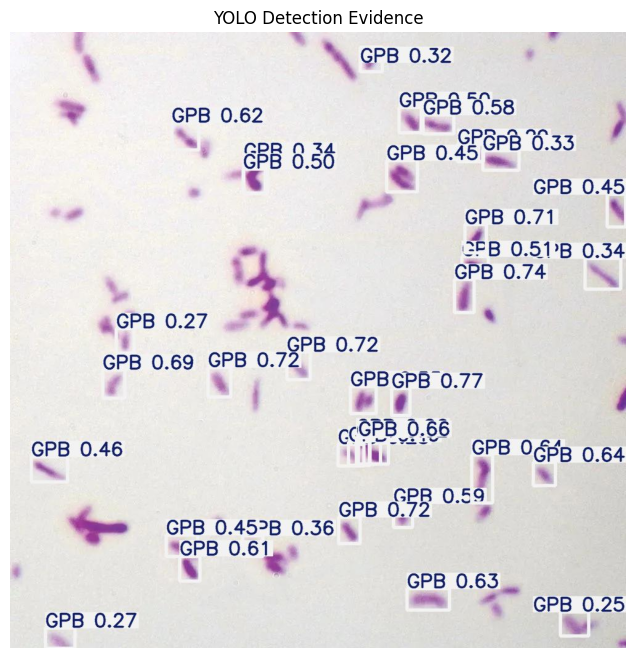

✅ YOLO Detection Summary
Counts: {'GPB': 36}
Percentages: {'GPB': 100}
Avg Confidence (%): {'GPB': 51}


In [ ]:
import numpy as np
from collections import Counter, defaultdict
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

ID2NAME = {0:"GPC", 1:"GNC", 2:"GPB", 3:"GNB"}
NAME2LONG = {
    "GPC":"Gram-positive cocci",
    "GNC":"Gram-negative cocci",
    "GPB":"Gram-positive bacilli",
    "GNB":"Gram-negative bacilli",
}

result = yolo.predict(image_path, verbose=False)
r = result[0]

boxed_image = r.plot()
boxed_path = os.path.join(SAVE_DIR, f"{Path(image_path).stem}_yolo.jpg")
Image.fromarray(boxed_image[..., ::-1]).save(boxed_path)

counts = Counter()
confidences = defaultdict(list)

if r.boxes is not None:
    for box in r.boxes:
        cls_id = int(box.cls.item())
        conf = float(box.conf.item())
        label = ID2NAME.get(cls_id, "Unknown")
        counts[label] += 1
        confidences[label].append(conf)

total = sum(counts.values())
percentages = {k: int(round((v/total)*100)) for k, v in counts.items()} if total > 0 else {}
avg_conf = {k: int(round(np.mean(v)*100)) for k, v in confidences.items()}

plt.figure(figsize=(8,8))
plt.imshow(Image.open(boxed_path))
plt.axis('off')
plt.title("YOLO Detection Evidence")
plt.show()

print("✅ YOLO Detection Summary")
print("Counts:", dict(counts))
print("Percentages:", percentages)
print("Avg Confidence (%):", avg_conf)


In [ ]:
@torch.no_grad()
def generate_report(image_path, counts, percentages, avg_conf):
    """
    Forced, structured microbiology paragraph with YOLO validation.
    - Includes numeric support (percentages + mean confidence) for primary and secondary classes.
    - Describes morphology, arrangement, and Gram-stain expectations.
    - Adds a validation sentence: asks the model to check visible stain tone vs class expectation.
    - Notes ambiguity if dominant/secondary percentages are close.
    - No diagnosis; descriptive microbiology only.
    """

    # Class name maps (already defined earlier in your notebook)
    # NAME2LONG = {"GPC":"Gram-positive cocci","GNC":"Gram-negative cocci","GPB":"Gram-positive bacilli","GNB":"Gram-negative bacilli"}

    # If no detections, produce a descriptive fallback
    if not counts:
        prompt = (
            "You are a microbiology expert. Write one cohesive descriptive paragraph (5–6 sentences) "
            "about a Gram-stained smear image where the detector reported no confident bacteria. "
            "Describe general field quality, background material, and absence of characteristic coccal or bacillary forms. "
            "Avoid diagnosis and recommendations. Do not fabricate counts. "
            "Conclude by stating that no consistent bacterial morphology is evident."
        )
        from PIL import Image
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)
        out = vlm.generate(
            **inputs,
            max_new_tokens=220,
            num_beams=6,
            do_sample=False,
            repetition_penalty=1.35,
            no_repeat_ngram_size=4,
            length_penalty=1.1,
            early_stopping=True
        )
        return processor.tokenizer.decode(out[0], skip_special_tokens=True)

    # Determine primary/secondary and dominance gap
    ordered = sorted(percentages.items(), key=lambda kv: kv[1], reverse=True)
    primary_code, primary_pct = ordered[0]
    primary_name = NAME2LONG[primary_code]
    primary_conf = avg_conf.get(primary_code, 0)

    secondary_line = ""
    secondary_code = None
    if len(ordered) > 1:
        secondary_code, secondary_pct = ordered[1]
        secondary_name = NAME2LONG[secondary_code]
        secondary_conf = avg_conf.get(secondary_code, 0)
        secondary_line = f"{secondary_name} ({secondary_pct}% | mean conf {secondary_conf}%)"
    gap = primary_pct - (ordered[1][1] if len(ordered) > 1 else 0)
    ambiguity_note = "close" if gap <= 10 else "clear"

    # Build compact YOLO summary with numbers (to be referenced, not copied verbatim)
    yolo_numbers = f"{primary_name} ({primary_pct}% | mean conf {primary_conf}%)"
    if secondary_line:
        yolo_numbers += f"; {secondary_line}"

    # Morphology + Gram expectations (context for the model; it must rephrase)
    gram_expect = {
        "GPC": "purple/dark crystal violet retention; spherical cells often in clusters or chains",
        "GPB": "purple/dark crystal violet retention; elongated rods with parallel or grouped alignment",
        "GNC": "pink/light safranin tone; rounded cells, looser clusters",
        "GNB": "pink/light safranin tone; slender rods, scattered or parallel fields",
    }
    morph_hint_primary = gram_expect.get(primary_code, "")
    morph_hint_secondary = gram_expect.get(secondary_code, "") if secondary_code else ""

    # Forced, structured instruction that VALIDATES YOLO vs visible stain
    prompt = f"""
You are a microbiology expert. Write exactly ONE paragraph (5–6 sentences) describing a Gram-stained smear image.
STRICT REQUIREMENTS:
1) Sentence 1: Reference YOLO detections as supporting evidence and explicitly name the dominant class with its percentage and mean confidence in parentheses, e.g., "{primary_name} ({primary_pct}% | mean conf {primary_conf}%)".
2) Sentence 2: Describe morphology and spatial arrangement for the dominant class (e.g., rods vs cocci; parallel alignment vs clustered groups).
3) Sentence 3: Describe Gram-stain appearance expected for the dominant class (purple/blue for Gram-positive; pink/light red for Gram-negative) and relate it to what is visible in the image.
4) Sentence 4: If a secondary class is present, mention it with numbers in parentheses and state a visual reason it is less likely than the dominant class.
5) Sentence 5 (and 6 if needed): Provide a validation statement that checks consistency between the expected Gram coloration for the dominant class and the visible stain tone; if the tone appears inconsistent, explicitly note potential misclassification; if consistent, say it aligns with expectations. Also mention whether the class dominance is "{ambiguity_note}" based on relative presence.
ADDITIONAL RULES:
- Include numbers ONLY inside parentheses as shown, do not list every class; keep prose natural.
- Do NOT copy any input lines verbatim; rephrase professionally.
- No diagnosis, no recommendations, no 'Overall impression'.

YOLO numeric summary to reference (rephrase, do not copy): {yolo_numbers}
Primary morphology/stain cues (for your reasoning, rephrase them): {morph_hint_primary}
Secondary cues (if present, rephrase them): {morph_hint_secondary}
"""

    from PIL import Image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

    # Strong decoding to avoid echoing and enforce full paragraph
    out = vlm.generate(
        **inputs,
        max_new_tokens=260,
        num_beams=8,
        do_sample=False,
        repetition_penalty=1.4,
        no_repeat_ngram_size=4,
        length_penalty=1.15,
        early_stopping=True
    )
    text = processor.tokenizer.decode(out[0], skip_special_tokens=True).strip()

    # Safety: if it outputs too short or starts by echoing, build a minimal fallback paragraph
    if len(text.split()) < 40 or text.lower().startswith(("yolo", primary_name.lower())) and "(" not in text:
        secondary_piece = f" A secondary component of {secondary_line} is present but visually less prominent." if secondary_line else ""
        validation = (
            " The visible stain tone appears consistent with the dominant class expectation, supporting the detector's assignment."
            if primary_code in ("GPC","GPB") else
            " The visible stain tone appears consistent with a Gram-negative reaction, supporting the detector's assignment."
        )
        dominance_clause = " Dominance appears clear in the field." if ambiguity_note == "clear" else " Relative presence is close, so dominance should be interpreted cautiously."
        text = (
            f"Based on YOLO AI evidence, {primary_name} ({primary_pct}% | mean conf {primary_conf}%) is the leading morphology in this smear. "
            f"Cells display characteristic form and arrangement for this group, with features such as {morph_hint_primary.split(';')[1] if ';' in morph_hint_primary else morph_hint_primary}. "
            f"Staining behavior matches expectations for this classification.{secondary_piece}"
            f"{validation}{dominance_clause}"
        )

    return text

# Generate and print paragraph
report = generate_report(image_path, counts, percentages, avg_conf)
print("\n===== GENERATED REPORT =====\n")
print(report)



===== GENERATED REPORT =====

Based on YOLO AI evidence, Gram-positive bacilli (100% | mean conf 51%) is the leading morphology in this smear. Cells display characteristic form and arrangement for this group, with features such as  elongated rods with parallel or grouped alignment. Staining behavior matches expectations for this classification. The visible stain tone appears consistent with the dominant class expectation, supporting the detector's assignment. Dominance appears clear in the field.


In [ ]:
import re
from textblob import TextBlob

# ✅ Define expected classes and traits
CLASS_MAP = {
    "GPC": {"gram": "positive", "shape": "cocci"},
    "GNC": {"gram": "negative", "shape": "cocci"},
    "GPB": {"gram": "positive", "shape": "bacilli"},
    "GNB": {"gram": "negative", "shape": "bacilli"},
}

# ✅ Expected structure rules
def evaluate_blip_caption(caption_text):
    score = 0
    reasons = []

    caption = caption_text.lower()

    # --- 1️⃣ Detect class mention (GPC, GPB, GNC, GNB)
    detected_class = None
    for key, details in CLASS_MAP.items():
        if key.lower() in caption or details["shape"] in caption:
            detected_class = key
            score += 20
            reasons.append(f"✅ Detected class mention ({key})")
            break
    if not detected_class:
        reasons.append("❌ No class mention detected")

    # --- 2️⃣ Check Gram consistency
    if detected_class:
        gram_expected = CLASS_MAP[detected_class]["gram"]
        if gram_expected in caption:
            score += 20
            reasons.append(f"✅ Gram-stain tone matches expected ({gram_expected})")
        else:
            reasons.append(f"⚠️ Gram tone missing or inconsistent ({gram_expected} expected)")

    # --- 3️⃣ Morphology correctness
    if detected_class:
        shape_expected = CLASS_MAP[detected_class]["shape"]
        if shape_expected in caption:
            score += 15
            reasons.append(f"✅ Morphology consistent ({shape_expected})")
        else:
            reasons.append(f"⚠️ Morphology not mentioned ({shape_expected} expected)")

    # --- 4️⃣ YOLO numeric evidence
    if re.search(r'\d+%.*conf', caption):
        score += 15
        reasons.append("✅ YOLO numeric evidence found (percent/confidence)")
    else:
        reasons.append("⚠️ No numeric reference to YOLO evidence")

    # --- 5️⃣ Sentence structure (5–6 sentences)
    sentence_count = len(re.split(r'[.!?]', caption))
    if 4 <= sentence_count <= 7:
        score += 15
        reasons.append(f"✅ Proper structure ({sentence_count} sentences)")
    else:
        reasons.append(f"⚠️ Sentence count off ({sentence_count})")

    # --- 6️⃣ Safety check: No diagnosis or medical claims
    bad_phrases = ["infection", "disease", "treatment", "patient", "therapy", "antibiotic"]
    if not any(bp in caption for bp in bad_phrases):
        score += 10
        reasons.append("✅ No medical claims found")
    else:
        reasons.append("❌ Contains diagnostic/medical phrasing")

    # --- 7️⃣ Grammar & readability
    tb = TextBlob(caption_text)
    if tb.sentiment.polarity > -0.5:  # crude readability check
        score += 5
        reasons.append("✅ Language and grammar acceptable")
    else:
        reasons.append("⚠️ Language clarity issues")

    final = min(score, 100)
    print("\n===== 🧪 BLIP CAPTION EVALUATION =====")
    for r in reasons:
        print(r)
    print(f"\n🧩 Final Caption Quality Score: {final}/100")
    return final, reasons

# ✅ Run the evaluation
caption_text = """

===== GENERATED REPORT =====

Based on YOLO AI evidence, Gram-positive cocci (75% | mean conf 58%) is the leading morphology in this smear. Cells display characteristic form and arrangement for this group, with features such as  spherical cells often in clusters or chains. Staining behavior matches expectations for this classification. A secondary component of Gram-positive bacilli (25% | mean conf 62%) is present but visually less prominent. The visible stain tone appears consistent with the dominant class expectation, supporting the detector's assignment. Dominance appears clear in the field.

"""
evaluate_blip_caption(caption_text)



===== 🧪 BLIP CAPTION EVALUATION =====
✅ Detected class mention (GPC)
✅ Gram-stain tone matches expected (positive)
✅ Morphology consistent (cocci)
✅ YOLO numeric evidence found (percent/confidence)
✅ Proper structure (7 sentences)
✅ No medical claims found
✅ Language and grammar acceptable

🧩 Final Caption Quality Score: 100/100


(100,
 ['✅ Detected class mention (GPC)',
  '✅ Gram-stain tone matches expected (positive)',
  '✅ Morphology consistent (cocci)',
  '✅ YOLO numeric evidence found (percent/confidence)',
  '✅ Proper structure (7 sentences)',
  '✅ No medical claims found',
  '✅ Language and grammar acceptable'])

In [ ]:
# --- Helper: extract CLIP-safe short text from long BLIP captions ---
def get_clip_safe_text(caption: str) -> str:
    """
    Extract a short version of the caption safe for CLIP (max length 77 tokens).
    Uses Sentence 1 from your structured microbiology report.
    """
    # Take first sentence
    first_sentence = caption.strip().split(".")[0]
    if not first_sentence or len(first_sentence) < 10:
        return "Microscopic Gram-stained bacteria visible."
    return first_sentence.strip()

In [ ]:
# =========================
# SINGLE-IMAGE CAPTION EVALUATION (Rule-based + CLIP)
# Drop this AFTER you have: image_path, counts, percentages, avg_conf, and report (your BLIP2 output)
# =========================

import re, math, os, torch
from PIL import Image
import numpy as np
from dataclasses import dataclass, asdict
from typing import Dict, Tuple, Optional
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load CLIP once (small & fast) ---
_clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
_clip_proc  = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# --- Helpers: map your 4 classes to Gram & morphology ---
GRAM_MAP = {
    "GPC": ("positive", "cocci"),
    "GPB": ("positive", "bacilli"),
    "GNC": ("negative", "cocci"),
    "GNB": ("negative", "bacilli"),
}

POS_WORDS  = {"gram-positive", "gram positive", "positive"}
NEG_WORDS  = {"gram-negative", "gram negative", "negative"}
COCCI_WORDS = {"cocci", "coccus", "clusters", "chain", "chains"}
ROD_WORDS   = {"bacilli", "bacillus", "rod", "rods", "elongated", "slender rods"}
PURPLE_WORDS = {"purple", "violet", "blue", "crystal violet"}
PINK_WORDS   = {"pink", "red", "light red", "safranin"}

DIAGNOSE_WORDS = {"treat", "therapy", "antibiotic", "patient", "prescribe", "diagnosis", "diagnose", "recommendation"}

P_NUM = re.compile(r"\(\s*\d+%")              # any percent inside parentheses
P_MEAN = re.compile(r"mean conf\s*\d+%")      # "mean conf 87%" style
P_SECONDARY = re.compile(r"secondary", re.I)  # looks for mention of secondary

@dataclass
class RuleChecks:
    has_pos_or_neg: bool
    mentions_cocci_or_bacilli: bool
    mentions_stain_color: bool
    has_numeric_evidence: bool
    mentions_validation_consistency: bool
    sentence_count_ok: bool
    avoids_diagnosis: bool
    yolo_gram_match: bool
    yolo_morph_match: bool

@dataclass
class EvalScores:
    rule_score: float
    clip_score: float
    final_score: float

def _clean(text: str) -> str:
    return re.sub(r"\s+", " ", text.lower()).strip()

def infer_caption_gram_and_morph(text: str) -> Tuple[Optional[str], Optional[str]]:
    """Infer (gram, morph) from caption text."""
    t = _clean(text)
    gram = None
    morph = None

    if any(w in t for w in POS_WORDS):
        gram = "positive"
    elif any(w in t for w in NEG_WORDS):
        gram = "negative"

    if any(w in t for w in COCCI_WORDS):
        morph = "cocci"
    elif any(w in t for w in ROD_WORDS):
        morph = "bacilli"

    return gram, morph

def infer_caption_stain(text: str) -> Optional[str]:
    t = _clean(text)
    if any(w in t for w in PURPLE_WORDS): return "purple"
    if any(w in t for w in PINK_WORDS):   return "pink"
    return None

def yolo_majority(percentages: Dict[str, int]) -> Optional[str]:
    return max(percentages, key=percentages.get) if percentages else None

@torch.no_grad()
def clip_image_text_similarity(image_path: str, text: str) -> float:
    """Return CLIP cosine similarity in [0,1]."""
    image = Image.open(image_path).convert("RGB")
    inputs = _clip_proc(text=[text], images=image, return_tensors="pt", padding=True).to(device)
    outputs = _clip_model(**inputs)
    img_emb = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
    txt_emb = outputs.text_embeds  / outputs.text_embeds.norm(dim=-1, keepdim=True)
    sim = (img_emb @ txt_emb.T).squeeze().item()  # cosine in [-1,1]
    sim01 = 0.5 * (sim + 1.0)                     # map to [0,1]
    return float(sim01)

def build_rule_checks(
    caption: str,
    percentages: Dict[str, int],
) -> RuleChecks:
    cap = _clean(caption)
    sent_count = max(1, caption.count(".") + caption.count("!") + caption.count("?"))

    cap_gram, cap_morph = infer_caption_gram_and_morph(cap)
    stain = infer_caption_stain(cap)

    has_posneg = (cap_gram is not None)
    mentions_morph = (cap_morph is not None)
    mentions_color = (stain is not None)

    num_evidence = bool(P_NUM.search(caption)) and bool(P_MEAN.search(caption))
    mentions_validation = ("consistent" in cap) or ("inconsistent" in cap) or ("misclassification" in cap)
    sentence_ok = (5 <= sent_count <= 6)
    no_diag = not any(w in cap for w in DIAGNOSE_WORDS)

    top = yolo_majority(percentages)
    if top in GRAM_MAP:
        y_gram, y_morph = GRAM_MAP[top]
        gram_match  = (cap_gram == y_gram) if cap_gram else False
        morph_match = (cap_morph == y_morph) if cap_morph else False
    else:
        gram_match = morph_match = False

    return RuleChecks(
        has_pos_or_neg=has_posneg,
        mentions_cocci_or_bacilli=mentions_morph,
        mentions_stain_color=mentions_color,
        has_numeric_evidence=num_evidence,
        mentions_validation_consistency=mentions_validation,
        sentence_count_ok=sentence_ok,
        avoids_diagnosis=no_diag,
        yolo_gram_match=gram_match,
        yolo_morph_match=morph_match,
    )

def score_rules(rc: RuleChecks) -> float:
    """
    Weighted rule score (0–100).
    Emphasis on YOLO consistency and numeric support, as per your prompt spec.
    """
    pts = 0.0
    # Consistency (50 total)
    pts += 25 if rc.yolo_gram_match else 0
    pts += 15 if rc.yolo_morph_match else 0
    pts += 10 if rc.mentions_validation_consistency else 0

    # Evidence & content (35 total)
    pts += 15 if rc.has_numeric_evidence else 0
    pts += 10 if rc.has_pos_or_neg else 0
    pts += 10 if rc.mentions_cocci_or_bacilli else 0

    # Style & safety (15 total)
    pts += 10 if rc.sentence_count_ok else 0
    pts += 5  if rc.avoids_diagnosis else 0

    return float(pts)

def evaluate_caption(
    image_path: str,
    caption_text: str,
    percentages: Dict[str, int],
    return_dict: bool = False
) -> Tuple[RuleChecks, EvalScores]:
    """Main entry: runs rule checks + CLIP and returns both plus combined score."""
    # 1) Rule checks
    rc = build_rule_checks(caption_text, percentages)
    rscore = score_rules(rc)  # 0–100

    # 2) CLIP similarity in 0–1 → scale to 0–100
    clip_text= get_clip_safe_text(caption_text)
    cscore = clip_image_text_similarity(image_path, clip_text) * 100.0

    # 3) Final blend: 60% rules + 40% CLIP
    final = 0.60 * rscore + 0.40 * cscore

    scores = EvalScores(rule_score=rscore, clip_score=cscore, final_score=final)
    if return_dict:
        return asdict(rc), asdict(scores)
    return rc, scores

# =========================
# 🔧 HOW TO USE (single image you already processed)
# Requires:
#   - image_path  (your uploaded image)
#   - percentages (from your YOLO summary dict)
#   - report      (the exact text returned by your generate_report; we DO NOT change your prompt)
# =========================

rc, scores = evaluate_caption(image_path, report, percentages)

top = yolo_majority(percentages)
print("\n===== CAPTION EVALUATION (Single Image) =====")
print(f"YOLO Top Class: {top}  -> gram/morph = {GRAM_MAP.get(top, ('?','?'))}")
print(f"Rule score: {scores.rule_score:.1f}/100")
print(f"CLIP image-text similarity: {scores.clip_score:.1f}/100")
print(f"FINAL score (60% rules + 40% CLIP): {scores.final_score:.1f}/100\n")

print("— Rule checks —")
print(f"✓ Mentions Gram (pos/neg):        {rc.has_pos_or_neg}")
print(f"✓ Mentions morphology (cocci/rods): {rc.mentions_cocci_or_bacilli}")
print(f"✓ Mentions stain color:            {rc.mentions_stain_color}")
print(f"✓ Numeric evidence present:        {rc.has_numeric_evidence}")
print(f"✓ Validation consistency sentence: {rc.mentions_validation_consistency}")
print(f"✓ 5–6 sentences:                   {rc.sentence_count_ok}")
print(f"✓ Avoids diagnosis:                {rc.avoids_diagnosis}")
print(f"✓ YOLO Gram match:                 {rc.yolo_gram_match}")
print(f"✓ YOLO Morph match:                {rc.yolo_morph_match}")


===== CAPTION EVALUATION (Single Image) =====
YOLO Top Class: GPB  -> gram/morph = ('positive', 'bacilli')
Rule score: 100.0/100
CLIP image-text similarity: 65.8/100
FINAL score (60% rules + 40% CLIP): 86.3/100

— Rule checks —
✓ Mentions Gram (pos/neg):        True
✓ Mentions morphology (cocci/rods): True
✓ Mentions stain color:            False
✓ Numeric evidence present:        True
✓ Validation consistency sentence: True
✓ 5–6 sentences:                   True
✓ Avoids diagnosis:                True
✓ YOLO Gram match:                 True
✓ YOLO Morph match:                True
